# Classification of boroughs in São Paulo

## Introduction

In this project, we aim to cluster the boroughs of São Paulo, Brazil, based on the price of their restaurants.
Generally more expensive restaurants are located in business or richer areas. On the other hand, cheaper restaurants tend to be more concentrated on more poor areas. This analysis can also be used to understand the purchasing power of the people who live in those boroughs. It can be useful to regular citizens to understand the costs of meals in their boroughs, and also to restaurateurs who are willing to expand their business and need to be aware of the boroughs that will allow then to keep their average ticket value. 

## Data

We will first get the São Paulo boroughs by scraping a Wikipedia page. We will then associate the latitude and longitude coordinates for each borough using Nominatim. Later, we will explore the number of restaurants per borough for each price level using the Foursquare APIs

In [331]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
!conda install -c conda-forge folium=0.5.0 --yes 
import folium
import json
from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

print("Done importing everything!")

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Done importing everything!


Let's get the boroughs from a Wikipedia page

In [332]:
#Do the request to retrieve the week page with Sao Paulo boroughs
url_sp_boroughs = "https://en.wikipedia.org/wiki/Subdivisions_of_São_Paulo"
page_text = requests.get(url_sp_boroughs).text

#From the whole html of the wiki page, let's separate the interesting table
page_html = BeautifulSoup(page_text,"lxml")
boroughs_table_html = page_html.find("table",class_="toccolours")

In [333]:
#Create the dataframe from the hmlt and check what is looks like
sp_boroughs = pd.read_html(str(boroughs_table_html))[0]
sp_boroughs

,Regional prefecture,Regional prefecture.1,Regional prefecture.2,Regional prefecture.3,Unnamed: 4
0,NaN,NaN,NaN,NaN,NaN
1,1.0,Aricanduva,NaN,17.0,M'Boi Mirim
2,2.0,Butantã,NaN,18.0,Mooca
3,3.0,Campo Limpo,NaN,19.0,Parelheiros
4,4.0,Capela do Socorro,NaN,20.0,Penha
5,5.0,Casa Verde,NaN,21.0,Perus
6,6.0,Cidade Ademar,NaN,22.0,Pinheiros
7,7.0,Cidade Tiradentes,NaN,23.0,Pirituba-Jaraguá
8,8.0,Ermelino Matarazzo,NaN,24.0,Santana-Tucuruvi
9,9.0,Freguesia-Brasilândia,NaN,25.0,Santo Amaro


In [334]:
#Drop the useless columns full of NaN
sp_boroughs.drop(["Regional prefecture","Regional prefecture.2","Regional prefecture.3"],axis=1,inplace=True)

#Drop the useless rows full of NaN
sp_boroughs.dropna(axis=0,inplace=True)

#The dataframe now has two interesting columns, we want to put all info in one single column

#Create an auxiliary dataframe with the last column
sp_boroughs_aux = sp_boroughs[["Unnamed: 4"]]
sp_boroughs_aux.columns = ["Regional prefecture.1"]

#Concatenate the original dataframe with the auxiliary one: put the info in the last column under in the 1st column
sp_boroughs = pd.concat([sp_boroughs,sp_boroughs_aux],ignore_index=True,axis=0,sort=False)

#The last column is now useless, drop it
sp_boroughs.drop(["Unnamed: 4"],axis=1,inplace=True)

#Rename the remaining column
sp_boroughs.columns = ["Borough"]

#Check out the result
sp_boroughs

,Borough
0,Aricanduva
1,Butantã
2,Campo Limpo
3,Capela do Socorro
4,Casa Verde
5,Cidade Ademar
6,Cidade Tiradentes
7,Ermelino Matarazzo
8,Freguesia-Brasilândia
9,Guaianases


We can get the latitude and longitude of each borough usign Nominatim

We will later use the Foursquare APIs to retrieve the number of restaurants in each borough per price level

In [335]:
#Function to retrieve the latitude from a borough in a given row
def get_latitude_borough_sp(row):
    address = row["Borough"] + ", São Paulo, SP, Brazil"
    geolocator = Nominatim(user_agent="sp_explorer_lat")
    try:
        location = geolocator.geocode(address)
    except GeocoderTimedOut:
        return get_latitude_borough_sp(row)
    try:
        return location.latitude
    except:
        return np.nan

#Function to retrieve the longitude from a borough in a given row
def get_longitude_borough_sp(row):
    address = row["Borough"] + ", São Paulo, SP, Brazil"
    geolocator = Nominatim(user_agent="sp_explorer_long")
    try:
        location = geolocator.geocode(address)
    except GeocoderTimedOut:
        return get_longitude_borough_sp(row)
    try:
        return location.longitude
    except:
        return np.nan

In [336]:
#Let's assign the latitudes of the boroughs in our dataframe
sp_boroughs["Latitude"] = sp_boroughs.apply(get_latitude_borough_sp, axis=1)

In [337]:
#Let's assign the longitudes of the boroughs in our dataframe
sp_boroughs["Longitude"] = sp_boroughs.apply(get_longitude_borough_sp, axis=1)

In [338]:
#Check it out
sp_boroughs

,Borough,Latitude,Longitude
0,Aricanduva,-23.572630,-46.518321
1,Butantã,-23.569131,-46.721874
2,Campo Limpo,-23.632558,-46.759666
3,Capela do Socorro,NaN,NaN
4,Casa Verde,-23.499124,-46.654098
5,Cidade Ademar,-23.669186,-46.658810
6,Cidade Tiradentes,-23.589151,-46.396426
7,Ermelino Matarazzo,-23.491674,-46.484070
8,Freguesia-Brasilândia,-23.483494,-46.687149
9,Guaianases,-23.555665,-46.409329


In [339]:
#Remove rows of boroughs that do not have latitude or longitude
sp_boroughs.dropna(axis=0,inplace=True)

#Reset the index after droping rows
sp_boroughs.reset_index(drop=True, inplace=True)

#Check it out
sp_boroughs

,Borough,Latitude,Longitude
0,Aricanduva,-23.572630,-46.518321
1,Butantã,-23.569131,-46.721874
2,Campo Limpo,-23.632558,-46.759666
3,Casa Verde,-23.499124,-46.654098
4,Cidade Ademar,-23.669186,-46.658810
5,Cidade Tiradentes,-23.589151,-46.396426
6,Ermelino Matarazzo,-23.491674,-46.484070
7,Freguesia-Brasilândia,-23.483494,-46.687149
8,Guaianases,-23.555665,-46.409329
9,Ipiranga,-23.589273,-46.606162


Let's get the latitude and longitude of the city to use when centering the plot

In [340]:
sp_address = 'São Paulo, SP, Brazil'

geolocator = Nominatim(user_agent="sp_explorer")
location = geolocator.geocode(sp_address)
sp_latitude = location.latitude
sp_longitude = location.longitude
print('The geograpical coordinate of Sao Paulo {}, {}.'.format(sp_latitude, sp_longitude))

The geograpical coordinate of Sao Paulo -23.5506507, -46.6333824.


### Ploting the data on the map

We can now plot the boroughs in the map

In [341]:
# create map of Toronto using latitude and longitude values
map_sp = folium.Map(location=[sp_latitude, sp_longitude], zoom_start=11)

# add markers to map
for lat, lng, borough in zip(sp_boroughs['Latitude'], sp_boroughs['Longitude'], sp_boroughs['Borough']):
    label = borough
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sp)  
    
map_sp

## Exploration of one borough

### Exploration on a fixed price level

Let's first explore one borough considering only restaurants on a fixed price level by calling the Foursquare API

In [342]:
#Get the latitude and longitude of one specific borough
lat, long = sp_boroughs.loc[28, "Latitude"], sp_boroughs.loc[28, "Longitude"]
print(lat, long)

-23.5837 -46.6327408242069


In [343]:
#Get the credentials to call Foursquare API
CLIENT_ID = ""
CLIENT_SECRET = ""
with open("credentials", "r") as credentials:
    CLIENT_ID = credentials.readline().replace("\n","")
    CLIENT_SECRET = credentials.readline().replace("\n","")
print("Done getting the credentials!")

Done getting the credentials!


In [344]:
#Define other parameters for the URL
RADIUS = 2000
VERSION = 20191123
LIMIT = 20
CATEGORY_ID = "4d4b7105d754a06374d81259" #Food category ID
SECTION = "food"
PRICE = "4"

#Construct the URL and perform the request
url="https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&section={}&categoryId{}&limit={}&price={}".format(CLIENT_ID,CLIENT_SECRET,VERSION,lat,long,RADIUS,SECTION,CATEGORY_ID,LIMIT,PRICE)
results = requests.get(url).json()

In [345]:
#Check out the results
results

{'meta': {'code': 200, 'requestId': '5ddadde647b43d00247d02b5'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Vila Mariana',
  'headerFullLocation': 'Vila Mariana, São Paulo',
  'headerLocationGranularity': 'neighborhood',
  'query': 'food',
  'totalResults': 2,
  'suggestedBounds': {'ne': {'lat': -23.565699981999984,
    'lng': -46.61313703928009},
   'sw': {'lat': -23.601700018000017, 'lng': -46.652344609133706}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '57c1c917cd10e5cf8220771d',
       'name': 'Outback Steakhouse',
       'location': {'address': 'Shopping Metrô Santa Cruz',
        'crossStreet': 'Piso L1',
        'lat': -23.5988323

We are interested in the total number of results returned for that price level

In [346]:
#Retrieve the total number of results returned for that price level
total_results = results["response"]["totalResults"]
total_results

2

### Exploration for all price levels

Foursquare defines 4 price levels: from 1 to 4, 1 being the cheapest and 4 being the most expensive. We need to call the API for each price level

In [347]:
#We go through each price level and perform the same operation done for a fixed price level
prices = ["1","2","3","4"]
for price in prices:
    url="https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&section={}&categoryId{}&limit={}&price={}".format(CLIENT_ID,CLIENT_SECRET,VERSION,lat,long,RADIUS,SECTION,CATEGORY_ID,LIMIT,price)
    results = requests.get(url).json()
    total_results = results["response"]["totalResults"]
    print("Total results for price",price," is",total_results)


Total results for price 1  is 67
Total results for price 2  is 124
Total results for price 3  is 32
Total results for price 4  is 2


## Exploration of all the boroughs

We are able to generalize the steps done previously for all boroughs with all price levels

In [348]:
for lat, long, index in zip(sp_boroughs["Latitude"],sp_boroughs["Longitude"],sp_boroughs.index):
    for price in prices:
        url="https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&section={}&categoryId{}&limit={}&price={}".format(CLIENT_ID,CLIENT_SECRET,VERSION,lat,long,RADIUS,SECTION,CATEGORY_ID,LIMIT,price)
        results = requests.get(url).json()
        total_results = results["response"]["totalResults"]
        sp_boroughs.loc[index,str(price)] = total_results

In [349]:
#Check out the results
sp_boroughs.head()

,Borough,Latitude,Longitude,1,2,3,4
0,Aricanduva,-23.572630,-46.518321,75.0,19.0,0.0,4.0
1,Butantã,-23.569131,-46.721874,88.0,69.0,6.0,2.0
2,Campo Limpo,-23.632558,-46.759666,65.0,37.0,3.0,3.0
3,Casa Verde,-23.499124,-46.654098,69.0,54.0,7.0,5.0
4,Cidade Ademar,-23.669186,-46.658810,64.0,31.0,4.0,2.0


In [350]:
#Rename the column names for more clarity
sp_boroughs.columns = ["Borough","Latitude","Longitude","Price level 1","Price level 2","Price level 3","Price level 4"]

In [351]:
#Double check if we have data for all boroughs and that columns have been renamed
sp_boroughs.describe(include="all")

,Borough,Latitude,Longitude,Price level 1,Price level 2,Price level 3,Price level 4
count,30,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
unique,30,NaN,NaN,NaN,NaN,NaN,NaN
top,Butantã,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,-23.562867,-46.601759,56.266667,46.333333,6.333333,2.966667
std,NaN,0.082980,0.114310,20.132207,42.384393,9.938894,2.025413
min,NaN,-23.824791,-46.759666,4.000000,3.000000,0.000000,0.000000
25%,NaN,-23.597966,-46.697556,48.500000,13.000000,1.000000,2.000000
50%,NaN,-23.564089,-46.629622,61.500000,27.500000,2.500000,3.000000
75%,NaN,-23.503068,-46.511948,67.000000,66.750000,6.750000,4.000000


## Data preparation

Let's separate the price levels data for our preparation

In [352]:
#Retrieve only the data in the columns for the price levels
price_data = sp_boroughs.iloc[:,3:]
price_data.head()

,Price level 1,Price level 2,Price level 3,Price level 4
0,75.0,19.0,0.0,4.0
1,88.0,69.0,6.0,2.0
2,65.0,37.0,3.0,3.0
3,69.0,54.0,7.0,5.0
4,64.0,31.0,4.0,2.0


Let's visualize what out price data looks like using boxplots

<function matplotlib.pyplot.show(*args, **kw)>

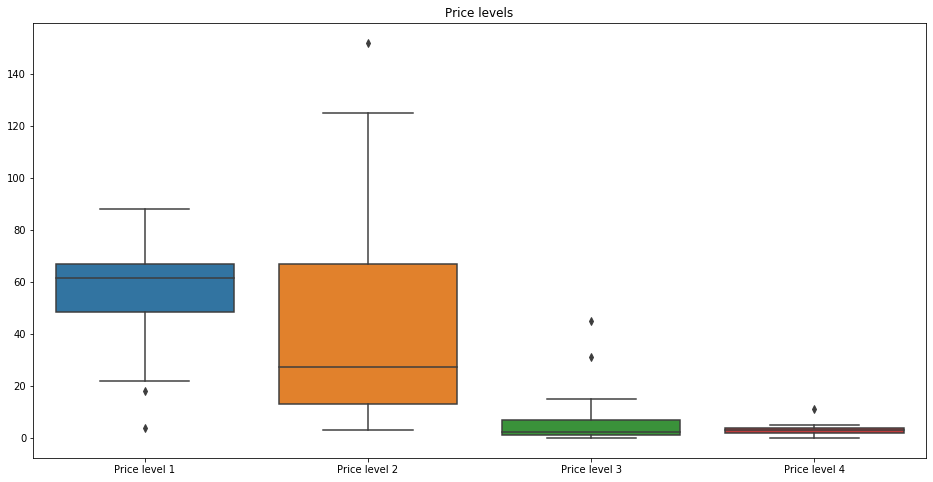

In [353]:
#Let's plot the boxplot for each price level
plt.figure(figsize=(16,8))
ax = sns.boxplot(data=price_data)
ax.set_title("Price levels")
plt.show

Since we do not have so much data for price level 4, we will drop it for better interpretation of the clusters

In [354]:
#Drop column for Price level 4
price_data.drop(["Price level 4"],axis=1,inplace=True)
price_data.head()

,Price level 1,Price level 2,Price level 3
0,75.0,19.0,0.0
1,88.0,69.0,6.0
2,65.0,37.0,3.0
3,69.0,54.0,7.0
4,64.0,31.0,4.0


We need to normalize the data for the price levels. To to data we will use the MinMax scaler, making the data range from 0 to 1

In [355]:
#Scale the price level data
scaled_price_data = MinMaxScaler().fit_transform(price_data)

Plot the scaled data for price levels using boxplots

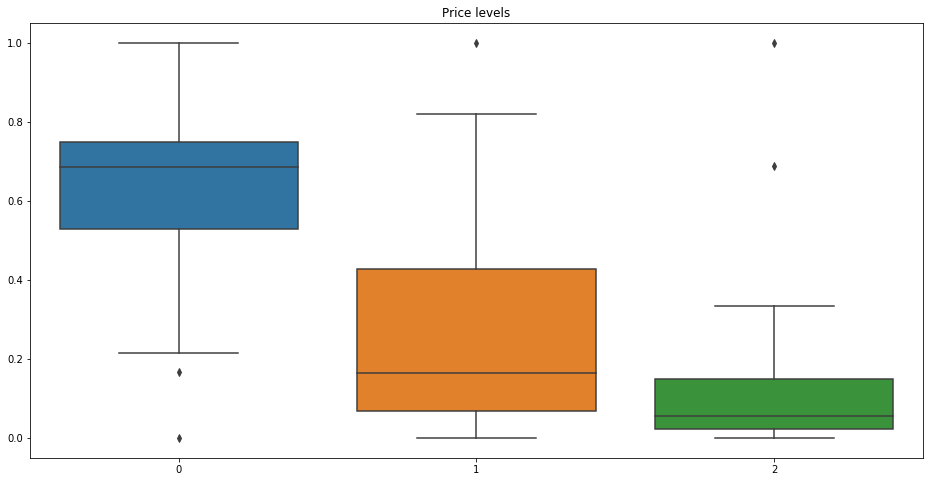

In [356]:
#Plot the price data using boxplots
plt.figure(figsize=(16,8))
ax = sns.boxplot(data=scaled_price_data)
ax.set_title("Price levels")
plt.show()

## Clustering the boroughs by price data

Cluster the boroughs using the price data and KMeans. We will use 3 clusters for the final analysis.

In [357]:
#Define the number of clusters
k = 3

#Cluster the boroughs with the price data using kmeans
kmeans = KMeans(init="k-means++",n_clusters=k,n_init=12)
kmeans.fit(scaled_price_data)

#Check the 10 first labels
kmeans.labels_[0:10]

array([2, 2, 2, 2, 2, 1, 2, 2, 1, 2], dtype=int32)

In [358]:
#Let's add the labels to our borough data
sp_boroughs["Cluster label"] = kmeans.labels_
sp_boroughs.head()

,Borough,Latitude,Longitude,Price level 1,Price level 2,Price level 3,Price level 4,Cluster label
0,Aricanduva,-23.572630,-46.518321,75.0,19.0,0.0,4.0,2
1,Butantã,-23.569131,-46.721874,88.0,69.0,6.0,2.0,2
2,Campo Limpo,-23.632558,-46.759666,65.0,37.0,3.0,3.0,2
3,Casa Verde,-23.499124,-46.654098,69.0,54.0,7.0,5.0,2
4,Cidade Ademar,-23.669186,-46.658810,64.0,31.0,4.0,2.0,2


### Ploting the clusters on the map

Let's plot the resulted clustes in the map of the city

In [359]:
# create map of Sao Paulo using latitude and longitude values
map_sp_cluster = folium.Map(location=[sp_latitude, sp_longitude], zoom_start=11)

#Set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#Add markers to the map
markers_colors = []
for lat, lon, borough, cluster in zip(sp_boroughs['Latitude'], sp_boroughs['Longitude'], sp_boroughs['Borough'], sp_boroughs['Cluster label']):
    label = folium.Popup(borough + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_sp_cluster)
    
map_sp_cluster

## Interpretation of clusters

To interpret the results of the clusters, we use the scaled price level data combined with the clusters' labels

In [360]:
#Create dataframe with the scaled price data
scaled_price_data_df = pd.DataFrame(scaled_price_data)
scaled_price_data_df.columns = ["Price level 1","Price level 2","Price level 3"]

#Add the labels from kmeans to the scaled data
scaled_price_data_df["Cluster label"] = kmeans.labels_
scaled_price_data_df.head()

,Price level 1,Price level 2,Price level 3,Cluster label
0,0.845238,0.107383,0.000000,2
1,1.000000,0.442953,0.133333,2
2,0.726190,0.228188,0.066667,2
3,0.773810,0.342282,0.155556,2
4,0.714286,0.187919,0.088889,2


To visualize the clusters, we plot the boxplots for the prices in each one of them

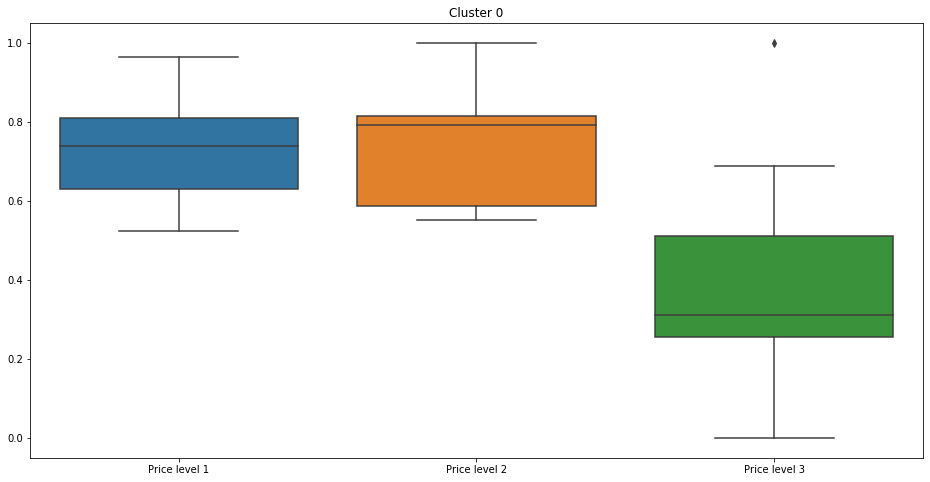

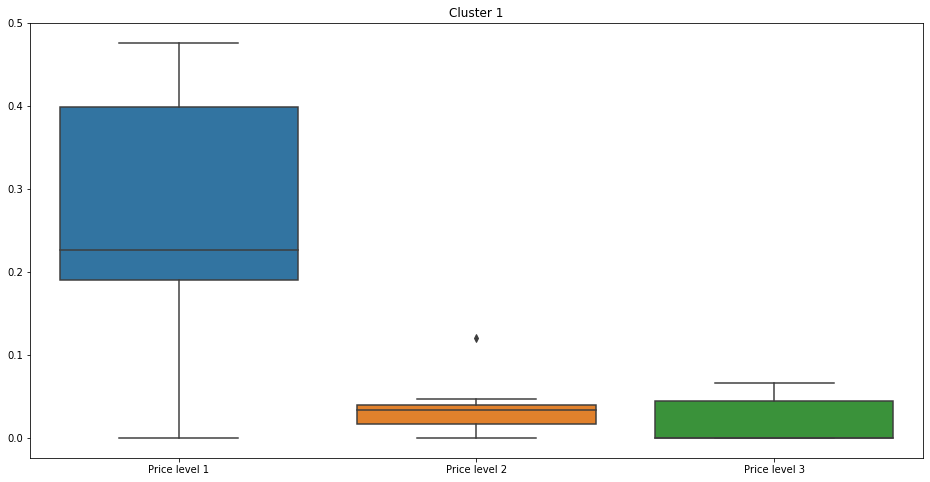

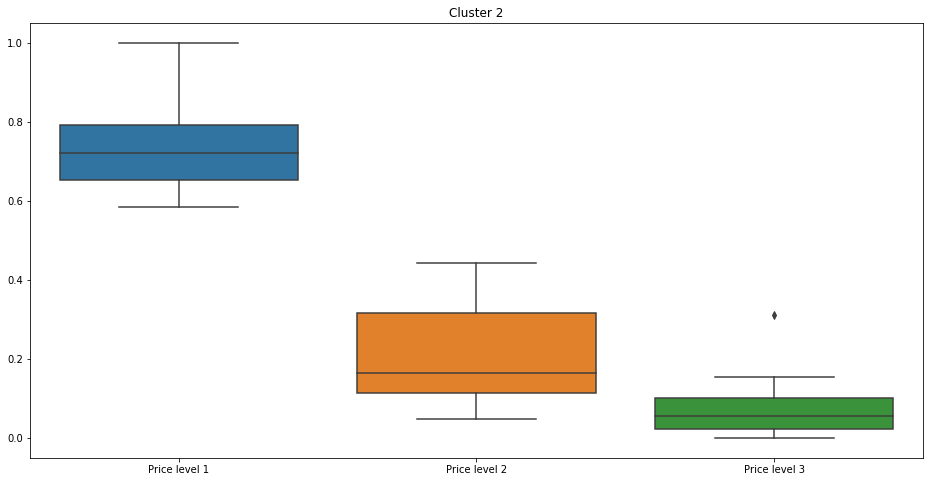

In [361]:
for i in range (k):
    plt.figure(figsize=(16,8))
    cluster_price_data=scaled_price_data_df.loc[scaled_price_data_df["Cluster label"] == i,:]
    ax = sns.boxplot(data=cluster_price_data.iloc[:,:-1])
    ax.set_title("Cluster " + str(i))
    plt.show()

We can notice that:
* Cluster 0 contains the boroughs with a big presence of restaurants in the cheapest price level. In general, these boroughs are located in the suburban areas of the city
* Cluster 1 contains the boroughs with more restaurants in the 3rd and 2nd price level, therefore with higher prices. These boroughs are located closer to city center and in business areas
* Cluster 2 contains boroughs with price levels mainly in the cheapest and medium cost. These boroughs are spread over the city, but are not business areas and neither are located in suburban areas
